# UPT DEMO

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tesspy import Tessellation

## Crash Dynamic

In [3]:
drone_profile={
    'mass': 1,
    'g': 9.81,
    'cd': 0.02,
    'cl': 0,
    'flight_lv': 400
    }


In [187]:
from pyproj import Proj
import pandas as pd
import geopandas as gpd
import numpy as np

#from . import ballistic_model, glide_model

def ballistic_model(n_sampling, ac_profile):
    sample_points = np.random.normal(15, 3, size=(n_sampling))
    mass = ac_profile['mass']
    g = ac_profile['g']
    cd = ac_profile['cd']
    flight_lv = ac_profile['flight_lv']
    
    gamma = np.sqrt(mass*g/cd)
    log2 = np.log(2)
    cd_z = cd*flight_lv
    m_per_c = mass/cd
    m_gamma = mass*gamma
    
    #Warning! Mathematically untested
    def ballistic(v_sample):
        point_list = []
        for v in v_sample:
            angle_degree = np.radians(np.random.uniform(0,360))
            ballistic_x = m_per_c*np.log(1+(v*((mass*log2+cd_z)/(m_gamma))))
            ballistic_y = m_per_c*np.log(1+(v*((mass*log2+cd_z)/(m_gamma))))
            
            radial_ballistic_func_x = lambda angle :ballistic_x*np.cos(angle)
            radial_ballistic_func_y = lambda angle :ballistic_y*np.sin(angle)
            x_point = radial_ballistic_func_x(angle_degree)
            y_point = radial_ballistic_func_y(angle_degree)
            point_list.append((x_point,y_point))
        return (np.array(point_list))

    crash_point = ballistic(sample_points)
    crash_point = np.column_stack((crash_point))
    return(crash_point)


class base_impact_model:
    def __init__(self, model, ac_profile, crs, n_sampling = 1000):
        self.model_type = model
        self.crs = crs
        self.n_sampling = n_sampling
        self.ac_profile = ac_profile
        self.get_function()
    
    def get_function(self):
        if self.model_type == "ballistic":
            self.model_func = ballistic_model
        if self.model_type == "glide":
            pass
    
    def run_model(self):
        self.impact_point = self.model_func(self.n_sampling, self.ac_profile)
        self.binning()
        self.array_to_gpd()
        self.pd_to_gpd()
        return(self.mask_gdf)
    
    def run_unbinned_model(self):
        self.impact_point = self.model_func(self.n_sampling, self.ac_profile)
        self.binning()
        return(self.historgram )
    
    def binning(self):
        bins = [np.linspace(self.impact_point.min(), self.impact_point.max(), 10), np.linspace(self.impact_point.min(), self.impact_point.max(), 10)]
        histogram, x_bin, y_bin  = np.histogram2d(self.impact_point[0], self.impact_point[1], bins=bins)
        self.historgram = histogram
        
        self.n_point_map = {}
        self.locmap_map = {}
        self.n_point_map.setdefault("N_points", [])
        self.locmap_map.setdefault("x_loc", [])
        self.locmap_map.setdefault("y_loc", [])
        for ith, _ in enumerate(histogram):
            for jth, point in enumerate(histogram[ith]):
                self.n_point_map['N_points'].append(point)
                self.locmap_map['x_loc'].append(x_bin[ith])
                self.locmap_map['y_loc'].append(y_bin[jth])
                
    def array_to_gpd(self):
        self.n_point_df = pd.DataFrame(self.n_point_map)
        self.locmap_df = pd.DataFrame(self.locmap_map)
        self.mask_df = self.n_point_df.join(self.locmap_df)
        
    def pd_to_gpd(self):
        self.mask_gdf = gpd.GeoDataFrame(self.mask_df.copy(), geometry=gpd.points_from_xy(self.mask_df['x_loc'], self.mask_df['y_loc']))
        self.mask_gdf.drop(['x_loc','y_loc'], axis=1, inplace = True)

        #Dividde N_point by sample size
        self.mask_gdf['N_points'] = self.mask_gdf['N_points']/self.n_sampling
        self.mask_gdf = self.mask_gdf.set_crs(self.crs)


<AxesSubplot: >

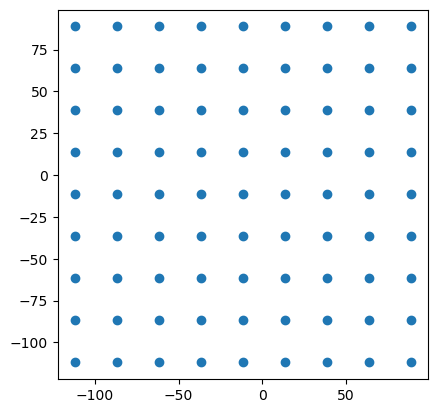

In [198]:
b = base_impact_model("ballistic", drone_profile,depok_school.crs)
gdf_mask = b.run_model()
gdf_mask.plot()

In [194]:
test_df = depok_school[depok_school['area']>1000]
idx = np.arange(0,test_df.shape[0])

In [199]:
def sjoin_calculator(array_index, mask, gdf):
    def sjoin_risk_sum(array_index):
        mask_translate = mask.copy()
        mask_translate['geometry'] = mask.translate(gdf.iloc[array_index][0].centroid.x,gdf.iloc[array_index][0].centroid.y)
        sjoin_gp = gpd.sjoin(gdf, mask_translate)
        risk = sjoin_gp['N_points'].multiply(sjoin_gp['area']).sum()
        return(risk)
    
    result_list = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(sjoin_risk_sum, idx)
    
        for result in results:
            result_list.append(result)

    return(result_list)

risk_calc = sjoin_risk(idx, gdf_mask, test_df)

In [112]:
depok_school['risk']=result_list

<AxesSubplot: >

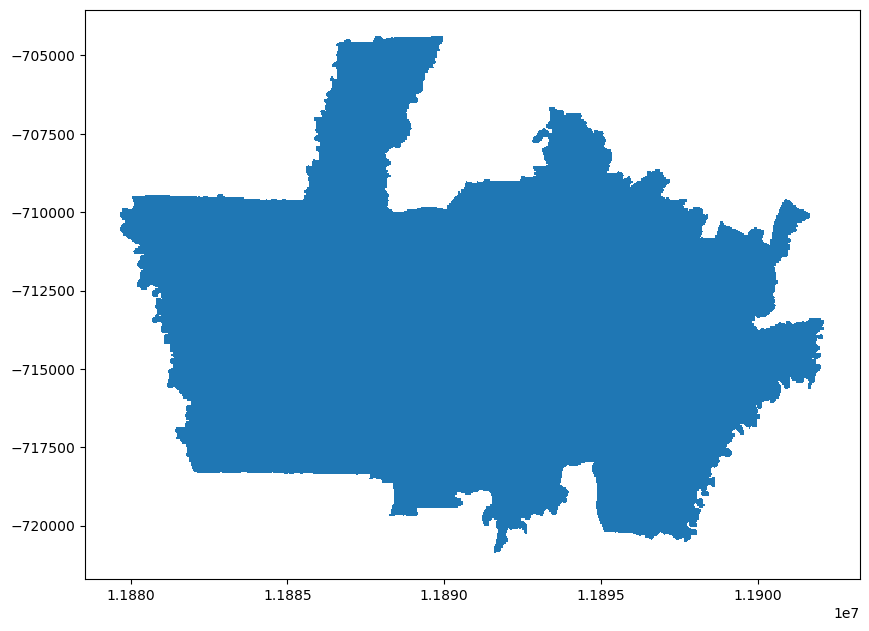

In [82]:
fig,ax = plt.subplots(figsize = (10,10)) 
depok_school.plot(ax=ax)
gdf_mask.plot(ax=ax)

In [37]:
af['area'].unique()

array([0.])

In [29]:
af.shape

(81, 6)

In [25]:
af['N_points'].unique()

array([nan])

In [ ]:
gdf_mask.plot()

In [ ]:
depok_school.plot()

In [ ]:
ax = depok_school.plot(markersize=.1, figsize=(12, 8), cmap='jet')
gdf_mask.plot()
plt.autoscale(False)

In [ ]:
depok_school.centroid

In [ ]:
ballistic_model.mask_df

In [ ]:
a, b = p(gdf_mask.centroid.x, gdf_mask.centroid.y)

In [ ]:
gdf_mask.plot(column="N_points")

In [ ]:
# ballistic_model = base_impact_model("ballistic", drone_profile,depok_school.estimate_utm_crs())
# gdf_mask = ballistic_model.mask_gdf
gdf_mask.plot(column="N_points")

In [ ]:
gdf_mask

In [ ]:
drs

In [ ]:
drs=depok_school.estimate_utm_crs().coordinate_operation

In [ ]:
def ballistic_model(n_sampling, ac_profile):
    sample_points = np.random.normal(15, 3, size=(n_sampling))
    mass = ac_profile['mass']
    g = ac_profile['g']
    cd = ac_profile['cd']
    flight_lv = ac_profile['flight_lv']
    
    gamma = np.sqrt(mass*g/cd)
    log2 = np.log(2)
    cd_z = cd*flight_lv
    m_per_c = mass/cd
    m_gamma = mass*gamma
    
    #Warning! Mathematically untested
    def ballistic(v_sample):
        point_list = []
        for v in v_sample:
            angle_degree = np.radians(np.random.uniform(0,360))
            ballistic_x = m_per_c*np.log(1+(v*((mass*log2+cd_z)/(m_gamma))))
            ballistic_y = m_per_c*np.log(1+(v*((mass*log2+cd_z)/(m_gamma))))
            
            radial_ballistic_func_x = lambda angle :ballistic_x*np.cos(angle)
            radial_ballistic_func_y = lambda angle :ballistic_y*np.sin(angle)
            x_point = radial_ballistic_func_x(angle_degree)
            y_point = radial_ballistic_func_y(angle_degree)
            point_list.append((x_point,y_point))
        return (np.array(point_list))

    crash_point = ballistic(sample_points)
    crash_point = np.column_stack((crash_point))
    return(crash_point)

In [ ]:
dist = ballistic_model(1000,aircraft_profile)

In [ ]:
bins = [np.linspace(dist.min(), dist.max(), 10), np.linspace(dist.min(), dist.max(), 10)]
histogram, x_bin, y_bin  = np.histogram2d(dist[0], dist[1], bins=bins)


n_point_map = {}
locmap_map = {}
n_point_map.setdefault("N_points", [])
locmap_map.setdefault("x_loc", [])
locmap_map.setdefault("y_loc", [])
for ith, _ in enumerate(histogram):
    for jth, point in enumerate(histogram[ith]):
        n_point_map['N_points'].append(point)
        locmap_map['x_loc'].append(x_bin[ith])
        locmap_map['y_loc'].append(y_bin[jth])
        

In [ ]:
import pandas as pd

n_point_df = pd.DataFrame(n_point_map)
locmap_df = pd.DataFrame(locmap_map)
mask_df = n_point_df.join(locmap_df)

In [ ]:
from pyproj import Proj
p = Proj(proj='utm',zone=48,ellps='WGS84', preserve_units=False)
mask_df['x_loc'], mask_df['y_loc'] = p(mask_df['x_loc'], mask_df['y_loc'], inverse=True)

In [ ]:
mask_df

In [ ]:
import geopandas as gpd
mask_gdf = gpd.GeoDataFrame(mask_df.copy(), geometry=gpd.points_from_xy(mask_df['x_loc'], mask_df['y_loc']))
mask_gdf.drop(['x_loc','y_loc'], axis=1, inplace = True)

#Dividde N_point by sample size
mask_gdf['N_points'] = mask_gdf['N_points']/1000

In [ ]:
mask_gdf.plot(column='N_points')

In [ ]:
from matplotlib import pyplot as plt 
plt.scatter(dist[0],dist[1],s=1)

### Basic Setup

In [6]:
from upt.preprocessor.features_of_interest import FeatureOfInterest as foi
from upt.postprocessor.a_star import AStar
from upt.utils.geo_utils import line_smoothing as lsp

import matplotlib.pyplot as plt


depok_obj = foi('Depok',crs="EPSG:3857",zoom_level=17)
depok_school = depok_obj.area_of_interest({'amenity': 'restaurant'})


depok_star = AStar(depok_school,'area',crs=depok_school.crs)
depok_path = depok_star.run_instance(3,1000)
way_marker = depok_star.create_line()
way_path = lsp(way_marker[:,0],way_marker[:,1],)

# ax = depok_school.plot(column="area",cmap='plasma')
# plt.plot(way_path[:,0], way_path[:,1],color='blue')

loaded
loaded
loaded gdf
EPSG:3857


In [79]:
depok_school.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
depok_school.plot()

In [ ]:
zen = np.random.normal(15, 3, size=(1000,2))
mass = 1
g = 9.81
c = 0.025
flight_lv  = 400

gamma = np.sqrt(mass*g/c)
log2 = np.log(2)
cy = c*flight_lv
mperc = mass/c
mgamma = mass*gamma
def ballistic(vx):
    x = mperc*np.log(1+(vx*((mass*log2+cy)/(mgamma))))
    y = mperc*np.log(1+(vx*((mass*log2+cy)/(mgamma))))
    return (y)
                        
vec_ball = np.vectorize(ballistic)
x_dist = vec_ball(zen)
plt.scatter(x_dist[0],x_dist[1])

In [ ]:
from shapely.geometry import Point, Polygon, box
from tesspy.tessellation_functions import get_squares_polyfill

In [ ]:
p_list = list(map(lambda point:Point(point),x_dist))
idx = np.arange(x_dist.shape[0])
point_gpd = gpd.GeoDataFrame({'Name':idx,'geometry':p_list})

In [ ]:
point_gpd.plot()

In [ ]:
sqr_poly = box(*point_gpd.total_bounds)

In [ ]:
sqr_poly

In [ ]:
sqr_df = gpd.GeoDataFrame({'Name':[1],'geometry':sqr_poly})

In [ ]:
sqr_tessel = get_squares_polyfill(sqr_df,21)

In [ ]:
sqr_tessel.plot(lw=4,edgecolor='w')

In [ ]:
sqr_tessel['id']=sqr_tessel.index
data_merged = gpd.sjoin(area_overlay, sqr_tessel, how="inner",predicate='within')
area_df = data_merged.groupby('id')['idx'].agg('sum')
final_gpd = pd.merge(square_grid, area_df, on='id', how='outer', indicator=False)

In [ ]:
sqr_tessel['id']=sqr_tessel.index

In [ ]:
sqr_tessel

In [ ]:
del sqr_tessel['children_id']

In [ ]:
point_gpd.crs is None

In [ ]:
sqr_tessel.crs

In [ ]:
point_gpd.crs

In [ ]:
point_gpd.set_crs('EPSG:4326')

In [ ]:
point_gpd = point_gpd.to_crs('epsg:4326')
point_gpd.crs  

In [ ]:
data_merged = gpd.sjoin(point_gpd, sqr_tessel, how="inner",predicate='within')

In [ ]:
data_merged

In [ ]:
point_gpd.plot()

In [ ]:
data_merged

In [ ]:
area_df = data_merged.groupby('index_right').agg('sum')

In [ ]:
sqr_tessel['id'] = sqr_tessel.index

In [ ]:
final_gpd = pd.merge(sqr_tessel, area_df, on='id', how='outer', indicator=False)

In [ ]:
area_df['id']=area_df.index

In [ ]:
final_gpd.fillna(0,inplace=True)

In [ ]:
final_gpd.plot(column='Name_right')

In [ ]:
plt.plot(x_dist)

In [ ]:
x_dist[1]

In [ ]:
import numpy as np

# Generate some random data
points = np.random.rand(100, 2)

# Define the bins for the histogram
bins = [np.linspace(x_dist.min(), x_dist.max(), 10), np.linspace(x_dist.min(), x_dist.max(), 10)]

# Use the histogram2d function to create the histogram
histogram, a, b = np.histogram2d(x_dist[:,0], x_dist[:,1], bins=bins)

# Print the histogram
print(histogram)

In [ ]:
b == a

In [ ]:
r = histogram.flatten()

In [ ]:
a[0]

In [ ]:
d_map = {}
p_map = {}
d_map.setdefault("N_points", [])
p_map.setdefault("Lon", [])
p_map.setdefault("Lat", [])
for ith, o in enumerate(histogram):
    for jth, k in enumerate(histogram[ith]):
        d_map['N_points'].append(k)
        p_map['Lon'].append(a[ith])
        p_map['Lat'].append(b[jth])
        

In [ ]:
histogram.shape

In [ ]:
import pandas as pd
p_dict = {'x':a,'y':b}
p_df = pd.DataFrame(p_map)
d_df = pd.DataFrame(d_map)
n_join = p_df.join(d_df)

In [ ]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(n_join, geometry=gpd.points_from_xy(n_join['Lon'], n_join['Lat']))

In [ ]:
gdf['N_points'].unique()

In [ ]:
gdf['N_points'] = gdf['N_points']/1000

In [ ]:
gdf.plot(column='N_points')

In [ ]:
from sklearn.preprocessing import normalize
p_hist = histogram/1000

In [ ]:
p_hist.max()

In [ ]:
n_hist.max()

In [ ]:
import numpy as np

# Generate some random data
points = np.random.rand(100, 2)

# Define the bins for the histogram
bins = [np.linspace(0, 1, 10), np.linspace(0, 1, 10)]

# Use the histogram2d function to create the histogram
histogram, _, _ = np.histogram2d(x_dist[:,0], x_dist[:,1], bins=bins)

# Print the histogram
print(histogram)

In [ ]:
points.max()

In [ ]:
points[:,0]

In [ ]:
np.flip(histogram,axis=0)

In [ ]:
from sklearn.preprocessing import normalize
zel = normalize(histogram)

In [ ]:
zel =histogram/histogram.max()

In [ ]:
histogram.max()

In [ ]:
zel

In [ ]:
help(np.histogram2d)

In [ ]:
histogram.mean()

In [ ]:
x_dist.shape

In [ ]:
point_gpd.total_bounds

In [ ]:
x_dist[0].max()

In [ ]:
import random

# Define the bounds of the simulation
x_min = 0
x_max = 100
y_min = 0
y_max = 100

# Number of iterations to run the simulation
num_iterations = 100000

# Counter to keep track of the number of points that fall within the region of interest
count = 0

# Run the simulation
for i in range(num_iterations):
  # Generate a random point within the bounds of the simulation
  x = random.uniform(x_min, x_max)
  y = random.uniform(y_min, y_max)

  # Check if the point falls within the region of interest
  if x**2 + y**2 <= 100:
    count += 1

# Calculate the probability that a randomly generated point falls within the region of interest
probability = count / num_iterations
print(probability)
print(count)